# 循环神经网络
- 作者 : *Jinhong Du*

- 参考资料: 
    
    1. https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
    2. https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767

# 目录

1. [导入相关包](#Sec1)
2. [设置超参数](#Sec2)
3. [准备数据](#Sec3)
4. [建立RNN模型](#Sec4)
    - [单个RNN细胞](#Sec4.1)
    - [交叉熵损失函数](#Sec4.2)
    - [准确率评估函数](#Sec4.3)
    - [可视化函数](#Sec4.4) 
    - [训练模型](#Sec4.5)
5. [建立RNN模型（使用TF modules）](#Sec5)

![1](https://github.com/jaydu1/TensorFlow-Tutorial/blob/master/img/10-1.png?raw=true)

## 1. 导入相关包<a id='Sec1'></a>

In [1]:
# 启动eager execution模式，必须在项目开始时运行
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

import numpy as np
import matplotlib.pyplot as plt

## 2. 设置超参数<a id='Sec2'></a>

In [2]:
NUM_EPOCH = 10
TOTAL_SERIES_LENGTH = 50000
TRUNCATED_BACKPROP_LENGTH = 15
state_size = 4
NUM_CLASS = 2
ECHO_STEP = 3
BATCH_SIZE = 5
NUM_BATCH = TOTAL_SERIES_LENGTH//BATCH_SIZE//TRUNCATED_BACKPROP_LENGTH
LERNING_RATE = 0.2

## 3. 准备数据<a id='Sec3'></a>

In [3]:
def generateData(total_series_length = TOTAL_SERIES_LENGTH, echo_step = ECHO_STEP, batch_size = BATCH_SIZE):
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]), dtype=np.int32)
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # 第一个索引变化最慢，相当于从x依次取出batch_size个元素作为新矩阵的每一行
    y = y.reshape((batch_size, -1))

    return (x, y)

## 4. 建立RNN模型<a id='Sec4'></a>

## 4.1 单个RNN细胞<a id='Sec4.1'></a>

In [4]:
class BasicRNNCell(object):
    def __init__(self, input_size, state_size, output_size, init_state):
        # 定义参数并初始化
        self.W = tfe.Variable(np.random.rand(input_size+state_size, state_size), dtype=tf.float32)
        self.b = tfe.Variable(np.zeros((1, state_size)), dtype=tf.float32)
        
        self.W2 = tfe.Variable(np.random.rand(state_size, output_size),dtype=tf.float32)
        self.b2 = tfe.Variable(np.zeros((1, output_size)), dtype=tf.float32)
        
        self.state = init_state
        
    def __call__(self, x):
        '''
        Input:
            x - list of tensor with shape [BATCH_SIZE, ] and length TIME_STEP
        '''
            
        batch_size = tf.shape(x[0])[0]
        
        states_series = []
        for current_input in x:
            current_input = tf.reshape(current_input, [batch_size, 1])
            input_and_state_concatenated = tf.concat([current_input, self.state], 1)

            next_state = tf.tanh(tf.matmul(input_and_state_concatenated, self.W) + self.b)  
            states_series.append(next_state)
            self.state = next_state
        logits_series = tf.stack([tf.matmul(state, self.W2) + self.b2 for state in states_series]) 
        predictions_series = tf.nn.softmax(logits_series)
        return predictions_series

## 4.2 交叉熵损失函数<a id='Sec4.2'></a>

In [5]:
def Loss(y_pred, y_true):
    '''
    Input:
        y_pred - [BATCH_SIZE * STEP_SIZE, NUM_CLASS]
        y      - [BATCH_SIZE * STEP_SIZE, NUM_CLASS]
    '''
    eps = 1e-6
    cliped_y_pref_tf = tf.clip_by_value(y_pred, eps, 1-eps)
    losses = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(cliped_y_pref_tf), axis=1))
    # losses = tf.losses.sparse_softmax_cross_entropy(y, y_logits)
    return losses

## 4.3 准确率评估函数<a id='Sec4.3'></a>

In [6]:
def Accuracy(y_pred, y_true):
    '''
    Input:
        y_pred - [BATCH_SIZE * STEP_SIZE, NUM_CLASS]
        y      - [BATCH_SIZE * STEP_SIZE, NUM_CLASS]
    '''
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true,1), tf.argmax(y_pred,1)),tf.float32))
    return accuracy

## 4.4 可视化函数<a id='Sec4.4'></a>

In [7]:
def plot(loss_list, accuracy_list, predictions_series, batchX, batchY):
    plt.figure(figsize=(12,8))
    ax = plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    ax.set_title('Loss')
    
    ax = plt.subplot(2, 3, 2)
    plt.cla()
    plt.plot(accuracy_list, 'r')
    ax.set_title('Accuracy')
    
    for batch_series_idx in range(4):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        ax = plt.subplot(2, 3, batch_series_idx + 3)
        plt.cla()
        plt.axis([0, TRUNCATED_BACKPROP_LENGTH, 0, 2])
        left_offset = range(TRUNCATED_BACKPROP_LENGTH)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")
        if batch_series_idx!=1:
            plt.yticks([])
        if batch_series_idx<1:
            plt.xticks([])
        ax.set_title('Batch %d'%(batch_series_idx+1))
    plt.draw()
    plt.pause(0.0001)

## 4.5 训练模型<a id='Sec4.5'></a>

Epoch  0: Average Loss 0.6901, Average Accuracy 0.5117
Epoch  1: Average Loss 0.1320, Average Accuracy 0.9456
Epoch  2: Average Loss 0.0032, Average Accuracy 0.9998
Epoch  3: Average Loss 0.0018, Average Accuracy 0.9999
Epoch  4: Average Loss 0.0014, Average Accuracy 0.9998


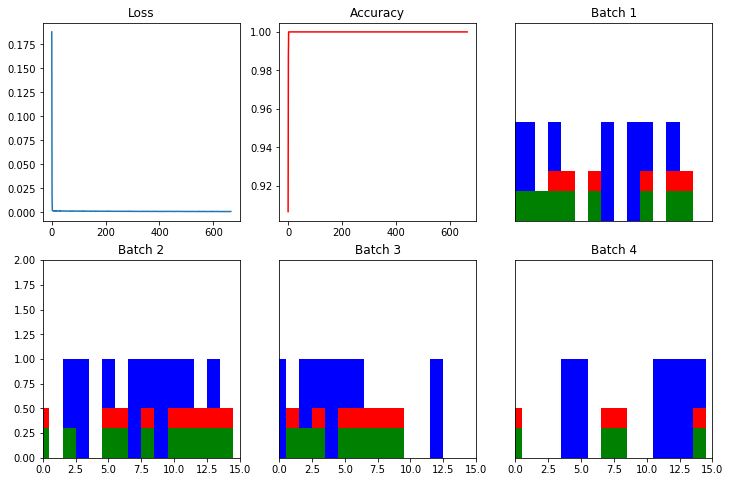

Epoch  5: Average Loss 0.0011, Average Accuracy 0.9999
Epoch  6: Average Loss 0.0009, Average Accuracy 0.9998
Epoch  7: Average Loss 0.0008, Average Accuracy 0.9999
Epoch  8: Average Loss 0.0010, Average Accuracy 0.9998
Epoch  9: Average Loss 0.0009, Average Accuracy 0.9999


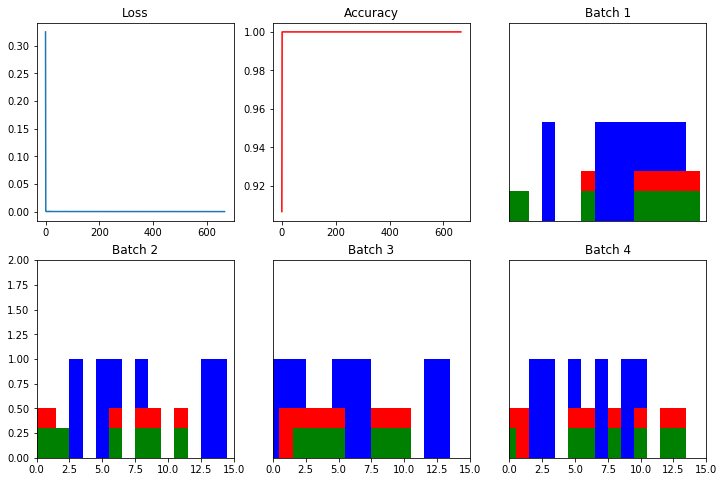

In [8]:
init_state = np.zeros((BATCH_SIZE, state_size), dtype=np.float32)
model = BasicRNNCell(1, state_size, NUM_CLASS, init_state)

for epoch_idx in range(NUM_EPOCH):
    x,y = generateData()
    # 每个epoch开始时初始化state
    model.state = np.zeros((BATCH_SIZE, state_size))

    loss_list = []
    accuracy_list = []
    for batch_idx in range(NUM_BATCH):
        # 准备一个Batch的数据
        start_idx = batch_idx * TRUNCATED_BACKPROP_LENGTH
        end_idx = start_idx + TRUNCATED_BACKPROP_LENGTH

        batchX = x[:,start_idx:end_idx]
        batchY = y[:,start_idx:end_idx]

        # 按时间t划分数据，前向传播时也是按照t依次进行
        inputs_series = tf.unstack(tf.cast(batchX, tf.float32), axis=1)
        labels_series = tf.unstack(batchY, axis=1)
        
        with tf.GradientTape() as t:
            # 前向传播
            y_pred = model(inputs_series)
            stack_y_pred = tf.reshape(y_pred, (-1,2))
            stack_y = tf.reshape(tf.one_hot(tf.stack(labels_series), NUM_CLASS), (-1,2))
            losses = Loss(stack_y_pred, stack_y)
            accuracy = Accuracy(stack_y_pred, stack_y)
            
        # 计算梯度，后向传播
        dW, db, dW2, db2 = t.gradient(losses, [model.W, model.b, model.W2, model.b2])
        model.W.assign_sub(LERNING_RATE * dW)
        model.b.assign_sub(LERNING_RATE * db)
        model.W2.assign_sub(LERNING_RATE * dW2)
        model.b2.assign_sub(LERNING_RATE * db2)        

        loss_list.append(losses)
        accuracy_list.append(accuracy)
        
    # 可视化
    print('Epoch %2d: Average Loss %.4f, Average Accuracy %.4f'%(epoch_idx, np.mean(loss_list), np.mean(accuracy_list)))
    if (epoch_idx+1)%5==0:
        x_test, y_test = generateData(total_series_length=BATCH_SIZE*TRUNCATED_BACKPROP_LENGTH)
        y_pred = model(tf.unstack(tf.cast(x_test, tf.float32), axis=1))
        plot(loss_list, accuracy_list, y_pred, x_test, y_test)

## 5. 建立RNN模型（使用TF modules）<a id='Sec5'></a>

In [9]:
class RNN(object):
    def __init__(self, input_size, state_size, output_size, init_state):
        self.cell = tf.nn.rnn_cell.BasicRNNCell(state_size, activation='tanh', dtype=tf.float32)
        self.cell.build((input_size))
        self.cell.variables[0].assign(np.random.rand(input_size + state_size, state_size))
        self.W2 = tfe.Variable(np.random.rand(state_size, output_size),dtype=tf.float32)
        self.b2 = tfe.Variable(np.zeros((1, output_size)), dtype=tf.float32)
        
        self.input_size = input_size
        self.state_size = state_size
        self.state = init_state
        
    def __call__(self, x):
        '''
        Input:
            x - list of tensor with shape [BATCH_SIZE, ] and length TIME_STEP
        '''
        batch_size = tf.shape(x)[1]
        states_series = []
        
        # Pass forward through time steps
        for current_input in x:
            current_input = tf.reshape(current_input, [batch_size,-1])
            state, next_state = self.cell(current_input, self.state)  # Broadcasted addition
   
            self.state = next_state
            states_series.append(state)
        # Alternative:
        # x = tf.reshape(x, (-1, batch_size, self.input_size))
        # states_series, current_state = tf.nn.dynamic_rnn(self.cell, x, initial_state=self.state, dtype=tf.float32, time_major=True)
        # self.state = current_state
        
        logits_series = tf.stack([tf.matmul(state, self.W2) + self.b2 for state in states_series])
        predictions_series = tf.nn.softmax(logits_series)
        return predictions_series

Epoch  0: Average Loss 0.6951, Average Accuracy 0.5011
Epoch  1: Average Loss 0.6951, Average Accuracy 0.4986
Epoch  2: Average Loss 0.6953, Average Accuracy 0.5020
Epoch  3: Average Loss 0.5437, Average Accuracy 0.6467
Epoch  4: Average Loss 0.0082, Average Accuracy 0.9997


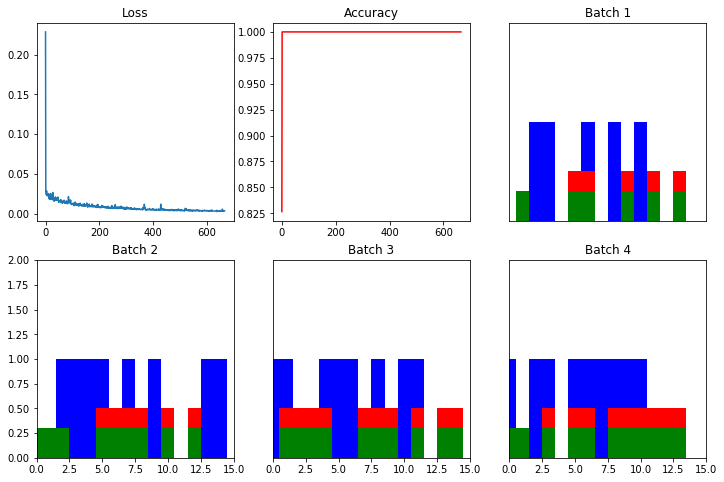

Epoch  5: Average Loss 0.0026, Average Accuracy 0.9999
Epoch  6: Average Loss 0.0017, Average Accuracy 0.9998
Epoch  7: Average Loss 0.0014, Average Accuracy 0.9998
Epoch  8: Average Loss 0.0013, Average Accuracy 0.9998
Epoch  9: Average Loss 0.0009, Average Accuracy 0.9999


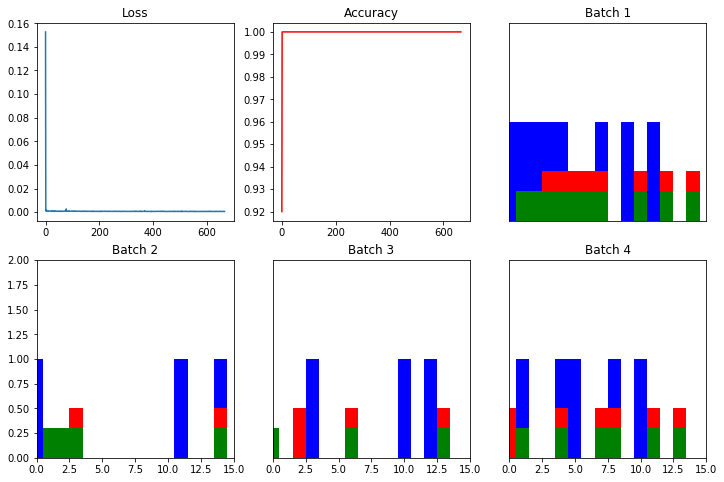

In [10]:
init_state = np.zeros((BATCH_SIZE, state_size), dtype=np.float32)
model = RNN(1, state_size, NUM_CLASS, init_state)

for epoch_idx in range(NUM_EPOCH):
    x,y = generateData()
    
    # Reset the initial state in each epoch
    model.state = init_state
    # Alternative:
    # model.state = model.cell.zero_state(BATCH_SIZE, dtype=tf.float32)
    
    loss_list = []
    accuracy_list = []
    for batch_idx in range(NUM_BATCH):
        # Prepare for batch data
        start_idx = batch_idx * TRUNCATED_BACKPROP_LENGTH
        end_idx = start_idx + TRUNCATED_BACKPROP_LENGTH

        batchX = x[:,start_idx:end_idx]
        batchY = y[:,start_idx:end_idx]

        inputs_series = tf.transpose(batchX.astype(np.float32),(1,0))
        labels_series = tf.unstack(batchY, axis=1)
        
        # Record forward pass
        with tf.GradientTape() as t:
            y_pred = model(inputs_series)
            stack_y_pred = tf.reshape(y_pred, (-1,2))
            stack_y = tf.reshape(tf.one_hot(tf.stack(labels_series), NUM_CLASS), (-1,2))
            losses = Loss(stack_y_pred, stack_y)
            accuracy = Accuracy(stack_y_pred, stack_y)

        # Compute grdients and back propagate
        delta = t.gradient(losses, [model.W2, model.b2] + model.cell.variables)
        model.W2.assign_sub(LERNING_RATE * delta[0])
        model.b2.assign_sub(LERNING_RATE * delta[1])
        for i in range(len(model.cell.variables)):
            model.cell.variables[i].assign_sub(LERNING_RATE * delta[i+2])
        
        loss_list.append(losses)
        accuracy_list.append(accuracy)
    
    # Visualize
    print('Epoch %2d: Average Loss %.4f, Average Accuracy %.4f'%(epoch_idx, np.mean(loss_list), np.mean(accuracy_list)))    
    if (epoch_idx+1)%5==0:
        x_test, y_test = generateData(total_series_length=BATCH_SIZE*TRUNCATED_BACKPROP_LENGTH)
        y_pred = model(tf.transpose(x_test.astype(np.float32),(1,0)))
        plot(loss_list, accuracy_list, y_pred, x_test, y_test)